In [ ]:
# packages
import numpy as np
import torch
import PIL
from PIL import Image
import torch.nn as nn
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
from torchvision.io import read_image
from matplotlib import pyplot as plt

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
# Non Augmented Custom Dataset

import os
import pandas as pd
from torchvision.io import read_image

class LSPDataset():
  # image_labels: List[Dict] of the filtered mpii annolist
  def __init__(self, image_labels, img_dir):
    self.image_labels = image_labels
    self.img_dir = img_dir
    # can add transforms if we need/want

  def __len__(self):
    return (self.image_labels.shape[0])

  def __getitem__(self, idx):
    # inputs
    # idx: int -> index of image sample
    #
    # image: torch.Tensor -> pytorch tensor representing image specified
    # label: list[dict] -> each dict contains x and y coordinate, joint id, and whether the joint is visible

    # img_path = self.img_dir + self.image_labels[idx]['image']['name']
    img_path = self.img_dir + "resized_im" + '0'*(5-len(str(idx+1))) + str(idx + 1) + ".jpg"
    image = read_image(img_path)

    label = self.image_labels[idx]

    return image, label

class MPIIDataset():
  # image_labels: List[Dict] of the filtered mpii annolist
  def __init__(self, image_labels, img_dir):
    self.image_labels = image_labels
    self.img_dir = img_dir
    # can add transforms if we need/want

  def __len__(self):
    return len(self.image_labels)

  def __getitem__(self, idx):
    # inputs
    # idx: int -> index of image sample
    #
    # image: torch.Tensor -> pytorch tensor representing image specified
    # label: list[dict] -> each dict contains x and y coordinate, joint id, and whether the joint is visible

    # img_path = self.img_dir + self.image_labels[idx]['image']['name']
    img_path = self.img_dir + "r_im" + '0'*(5-len(str(idx))) + ".jpg"
    image = read_image(img_path)

    label = self.image_labels['annorect']['annopoints']['point']

    return image, label


In [ ]:
def get_image_sizes(folder_path):
    """
    retreive the sizes of the original images
    """
    sizes = []
    image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    # Iterate over files in the folder
    for filename in image_files:

      file_path = os.path.join(folder_path, filename)

      # Open the image using PIL
      with Image.open(file_path) as img:
          # Get the size of the image (width, height)
          img_size = img.size
          sizes.append(img_size)

    return sizes

def resize_joints(joints, resize_dim, original_dim):
  """
  returns the new joint coordinate in the reshaped image
  """
  new = np.zeros((14,3))
  for idx, point in enumerate(joints):
    x1 = int((point[0] * (resize_dim[0] / original_dim[0])))
    y1 = int((point[1] * (resize_dim[1] / original_dim[1])))
    new[idx,:] = [x1,y1,point[2]] # append resized coordinate
  return new


# plotting functions:
def plot_with_joints(img, joints):
  """
  Plots an image overlayed with the joints
  """

  img = np.swapaxes(img,0,2)
  img = np.swapaxes(img,0,1)
  plt.scatter(joints[:,0],joints[:,1])
  plt.imshow(img)
  plt.show()






In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
class ViT():
  def _init_(self):
    self.img_size = (224,224)
    self.patch_size = (16,16)

    self.embeddings = PatchEmbeddings()

  def forward(self,x):
    x = self.embeddings(x)
    return x

In [ ]:
import embeddings

In [ ]:
from torch.nn import functional as F
#Not sure if this will handle batches but it should we may just need to make adjustments

class attentionHead(nn.Module):
  def __init__(self):
    super().__init__()
    self.feats = 768 #TODO abstract this
    self.firstlin = nn.Linear(self.feats,self.feats*3)

  def forward(self,x):
    """
    x :
    """

    dim = 768
    x = torch.transpose(x,0,1)
    x = self.firstlin(x)
    x = torch.reshape(x,(12,3,196,64)) #TODO change this to 197 when CLS gets added and abstract all these numbers
                                       #DO NOT ABSTRACT the numbers for the transposes those are encoding which dimension to move

    Q,K,V = torch.unbind(x,1)
    QK = torch.matmul(Q,torch.transpose(K,2,1))
    QK = F.softmax(QK,dim = -1) #May need to swap dimension of softmax
    out = torch.matmul(QK,V)
    out = torch.transpose(out,0,1)
    out = torch.flatten(out, start_dim = 1)
    return out






In [ ]:
i = read_image('/content/drive/MyDrive/JointPoseEstimation/Data/lsp/images/im00001.jpg')

resizer = transforms.Resize((224,224))
i = resizer(i)
patchembedder = PatchEmbeddings()
tensor = patchembedder(i)


attention_head = attentionHead()
tensor = attention_head(tensor)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
# get og image sizes :
folder_path = '/content/drive/MyDrive/JointPoseEstimation/Data/lsp/images'
sizes = get_image_sizes(folder_path)

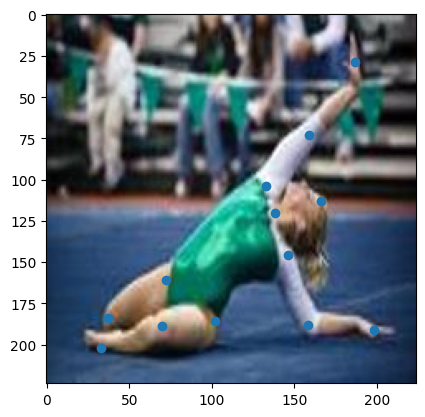

In [ ]:

# testing that joints line up with images
im = read_image('/content/drive/MyDrive/JointPoseEstimation/Data/lsp/images224/resized_im00001.jpg')
im_og = Image.open('/content/drive/MyDrive/JointPoseEstimation/Data/lsp/images/im00001.jpg')
annot = np.load('/content/drive/MyDrive/JointPoseEstimation/Data/lsp/leeds_sports_extended.npy')
annot_s = np.swapaxes(annot, 0,2)
annot_s = np.swapaxes(annot_s,1,2)


resized_joints = resize_joints(annot_s[0],im.shape[1:],im_og.size)
plot_with_joints(im,resized_joints)


In [ ]:
# dataloader stuff

annot_s = np.swapaxes(annot, 0,2)
annot_s = np.swapaxes(annot_s,1,2)

dataset = LSPDataset(annot_s,"/content/drive/MyDrive/JointPoseEstimation/Data/lsp/images224/")
print(annot_s.shape)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

(10000, 14, 3)
[(157, 105), (194, 265), (320, 427), (157, 236), (219, 164), (391, 260), (188, 250), (247, 371), (358, 238), (324, 216), (243, 162), (148, 221), (178, 237), (191, 127), (317, 198), (254, 381), (195, 292), (563, 374), (272, 363), (163, 246), (272, 181), (382, 255), (261, 391), (280, 187), (234, 176), (144, 217), (136, 182), (325, 217), (347, 347), (637, 426), (182, 136), (340, 227), (194, 145), (201, 297), (126, 134), (309, 206), (290, 217), (163, 109), (457, 305), (776, 515), (228, 171), (211, 141), (140, 210), (450, 300), (210, 158), (161, 201), (179, 268), (391, 261), (334, 216), (556, 417), (167, 94), (105, 158), (269, 203), (244, 367), (437, 293), (359, 271), (240, 360), (301, 201), (156, 185), (392, 261), (291, 351), (362, 268), (290, 194), (245, 163), (181, 272), (472, 294), (360, 477), (638, 359), (141, 223), (268, 402), (417, 625), (459, 681), (147, 199), (392, 262), (527, 395), (288, 192), (175, 262), (346, 359), (432, 324), (167, 209), (195, 259), (145, 218), (

In [ ]:
# training loop
model = ViT()
print(len(train_loader.dataset))
for epoch in range(1):

  acc_loss = 0
  for img, label in (train_loader):
    # Move the batch to the device
    img, label = img.to(device) , label.to(device)
    output = model()



10000


KeyboardInterrupt: ignored